In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Class representing a 2D Ising model
class Ising:
    def __init__(self, N, J, H):
        self.lattice = np.random.choice([-1,1], size=(N,N)) # initial state
        self.N = N # dimension
        self.J = np.abs(J) # interaction energy, non-negative by definition
        self.H = H # external field

In [3]:
# Function to calculate energy change when spin(i,j) is flipped, assuming periodic boundary conditions
def energy_change_of_flip(state, pos_i, pos_j):
    return 2*state.lattice[pos_i,pos_j]*(state.J*(state.lattice[pos_i,(pos_j+1)%state.N] + state.lattice[(pos_i-1)%state.N,pos_j] + state.lattice[(pos_i+1)%state.N,pos_j] + state.lattice[pos_i,(pos_j-1)%state.N])+state.H)

In [4]:
# Monte Carlo sweep using Metropolis algorithm
def monte_carlo_sweep(state, temperature):
    for i in range(len(state.lattice)**2):
        # pick a spin randomly and calculate energy change if it's flipped
        pos_i = np.random.randint(0,len(state.lattice))
        pos_j = np.random.randint(0,len(state.lattice))
        delta_E = energy_change_of_flip(state,pos_i,pos_j)
        
        # to flip or not to flip?
        if delta_E < 0 or np.exp(-delta_E/temperature) > np.random.random():
            state.lattice[pos_i,pos_j] *= -1

In [5]:
# Function to calculate magnetisation
def calculate_magnetisation(state):
    return np.sum(state.lattice)

In [6]:
# Function to calculate energy
def calculate_energy(state):
    interaction_energy = 0.0
    for pos_i in range(len(state.lattice)):
        for pos_j in range(len(state.lattice)):
            interaction_energy += -state.J*state.lattice[pos_i,pos_j]*(state.lattice[pos_i,(pos_j+1)%state.N] + state.lattice[(pos_i-1)%state.N,pos_j] + state.lattice[(pos_i+1)%state.N,pos_j] + state.lattice[pos_i,(pos_j-1)%state.N])
    interaction_energy *= 0.5 # avoid double counting
    
    magnetisation_energy = -state.H*calculate_magnetisation(state)
    
    return interaction_energy+magnetisation_energy

T = 0.5, reached step 0
T = 0.5, reached step 100
T = 0.5, reached step 200
T = 0.5, reached step 300
T = 0.5, reached step 400
T = 0.5, reached step 500
T = 0.5, reached step 600
T = 0.5, reached step 700
T = 0.5, reached step 800
T = 0.5, reached step 900
T = 0.5, reached step 1000
T = 0.5, reached step 1100
T = 0.5, reached step 1200
T = 0.5, reached step 1300
T = 0.5, reached step 1400
T = 0.5, reached step 1500
T = 0.5, reached step 1600
T = 0.5, reached step 1700
T = 0.5, reached step 1800
T = 0.5, reached step 1900
T = 0.5, reached step 2000
T = 0.5, reached step 2100
T = 0.5, reached step 2200
T = 0.5, reached step 2300
T = 0.5, reached step 2400
T = 0.5, reached step 2500
T = 0.5, reached step 2600
T = 0.5, reached step 2700
T = 0.5, reached step 2800
T = 0.5, reached step 2900
T = 0.5, reached step 3000
T = 0.5, reached step 3100
T = 0.5, reached step 3200
T = 0.5, reached step 3300
T = 0.5, reached step 3400
T = 0.5, reached step 3500
T = 0.5, reached step 3600
T = 0.5, reac

T = 4.0, reached step 9800
T = 4.0, reached step 9900


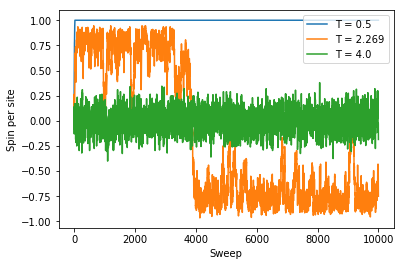

In [7]:
# Investigating dependence of time taken (represented by no. of sweeps) to reach equilibrium on temperature, H=0
N = 20
J = 1.0
H = 0.0

temperature_range = [0.5, 2.269, 4.0] # one below T_c, T_c, one above T_c
number_of_sweeps = 10000

spin_per_site = np.zeros((len(temperature_range),number_of_sweeps)) # array to store data

for t_index in range(len(temperature_range)):
    state = Ising(N,J,H)
    
    for sweep in range(number_of_sweeps):
        monte_carlo_sweep(state,temperature_range[t_index])
        spin_per_site[t_index,sweep] = calculate_magnetisation(state)/(state.N**2)
        
        if sweep%100 == 0: # output checkpoint
            print('T = {0}, reached step {1}'.format(temperature_range[t_index],sweep))
    
    plt.plot(range(number_of_sweeps),spin_per_site[t_index,:],label='T = {0}'.format(temperature_range[t_index])) # plot data

plt.legend(loc='upper right')
plt.xlabel('Sweep')
plt.ylabel('Spin per site')
plt.savefig('plots/Spin_per_site_vs_Sweep_zeroH.png')

T = 0.5, reached step 0
T = 0.5, reached step 100
T = 0.5, reached step 200
T = 0.5, reached step 300
T = 0.5, reached step 400
T = 0.5, reached step 500
T = 0.5, reached step 600
T = 0.5, reached step 700
T = 0.5, reached step 800
T = 0.5, reached step 900
T = 0.5, reached step 1000
T = 0.5, reached step 1100
T = 0.5, reached step 1200
T = 0.5, reached step 1300
T = 0.5, reached step 1400
T = 0.5, reached step 1500
T = 0.5, reached step 1600
T = 0.5, reached step 1700
T = 0.5, reached step 1800
T = 0.5, reached step 1900
T = 0.5, reached step 2000
T = 0.5, reached step 2100
T = 0.5, reached step 2200
T = 0.5, reached step 2300
T = 0.5, reached step 2400
T = 0.5, reached step 2500
T = 0.5, reached step 2600
T = 0.5, reached step 2700
T = 0.5, reached step 2800
T = 0.5, reached step 2900
T = 0.5, reached step 3000
T = 0.5, reached step 3100
T = 0.5, reached step 3200
T = 0.5, reached step 3300
T = 0.5, reached step 3400
T = 0.5, reached step 3500
T = 0.5, reached step 3600
T = 0.5, reac

T = 4.0, reached step 9800
T = 4.0, reached step 9900


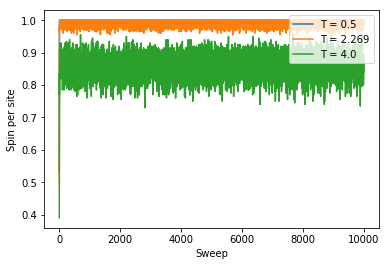

In [8]:
# Investigating dependence of time taken (represented by no. of sweeps) to reach equilibrium on temperature, H=/=0
N = 20
J = 1.0
H = 2.0

temperature_range = [0.5, 2.269, 4.0] # one below T_c, T_c, one above T_c
number_of_sweeps = 10000

spin_per_site = np.zeros((len(temperature_range),number_of_sweeps)) # array to store data

for t_index in range(len(temperature_range)):
    state = Ising(N,J,H)
    
    for sweep in range(number_of_sweeps):
        monte_carlo_sweep(state,temperature_range[t_index])
        spin_per_site[t_index,sweep] = calculate_magnetisation(state)/(state.N**2)
        
        if sweep%100 == 0: # output checkpoint
            print('T = {0}, reached step {1}'.format(temperature_range[t_index],sweep))
    
    plt.plot(range(number_of_sweeps),spin_per_site[t_index,:],label='T = {0}'.format(temperature_range[t_index])) # plot data

plt.legend(loc='upper right')
plt.xlabel('Sweep')
plt.ylabel('Spin per site')
plt.savefig('plots/Spin_per_site_vs_Sweep_nonzeroH.png')

In [17]:
# Dependence of mean magnetisation and energy on temperature, H=0
N = 20
J = 1.0
H = 0.0

temperature_range = np.linspace(0.5,4.0,50)  # 40 values of temperature between 0.5 and 4.0
number_of_equilibrating_sweeps = 1000
number_of_sampling_sweeps = 500

# arrays to store average energy, magnetisation, specific heat, susceptibility
average_energy = np.zeros(len(temperature_range))
average_magnetisation = np.zeros(len(temperature_range))
average_heat_capacity = np.zeros(len(temperature_range))
average_susceptibility = np.zeros(len(temperature_range))

for t_index in range(len(temperature_range)):
    state = Ising(N,J,H)
    
    # wait for the system to settle down
    for sweep in range(number_of_equilibrating_sweeps):
        monte_carlo_sweep(state,temperature_range[t_index])
        if sweep%100 == 0: # output checkpoint
            print('T = {0}, equilibrating step {1}'.format(temperature_range[t_index],sweep))
    
    sum_of_energy = 0.0
    sum_of_energy_squared = 0.0
    sum_of_magnetisation = 0.0
    sum_of_magnetisation_squared = 0.0
    
    # start sampling data
    for sweep in range(number_of_sampling_sweeps):
        monte_carlo_sweep(state,temperature_range[t_index])
        
        # store data
        E = calculate_energy(state)
        M = np.abs(calculate_magnetisation(state))
        sum_of_energy += E
        sum_of_energy_squared += E**2
        sum_of_magnetisation += M
        sum_of_magnetisation_squared += M**2
        
        if sweep%100 == 0: # output checkpoint
            print('T = {0}, sampling step {1}'.format(temperature_range[t_index],sweep))
    
    # average over number of sweeps
    average_energy[t_index] = (sum_of_energy/number_of_sampling_sweeps)/(state.N**2)
    average_magnetisation[t_index] = (sum_of_magnetisation/number_of_sampling_sweeps)/(state.N**2)
    average_heat_capacity[t_index] = ((sum_of_energy_squared/number_of_sampling_sweeps-(sum_of_energy/number_of_sampling_sweeps)**2)/(temperature_range[t_index]**2))/(state.N**2)
    average_susceptibility[t_index] = ((sum_of_magnetisation_squared/number_of_sampling_sweeps-(sum_of_magnetisation/number_of_sampling_sweeps)**2)/temperature_range[t_index])/(state.N**2)

T = 0.5, equilibrating step 0
T = 0.5, equilibrating step 100
T = 0.5, equilibrating step 200
T = 0.5, equilibrating step 300
T = 0.5, equilibrating step 400
T = 0.5, equilibrating step 500
T = 0.5, equilibrating step 600
T = 0.5, equilibrating step 700
T = 0.5, equilibrating step 800
T = 0.5, equilibrating step 900
T = 0.5, sampling step 0
T = 0.5, sampling step 100
T = 0.5, sampling step 200
T = 0.5, sampling step 300
T = 0.5, sampling step 400
T = 0.5714285714285714, equilibrating step 0
T = 0.5714285714285714, equilibrating step 100
T = 0.5714285714285714, equilibrating step 200
T = 0.5714285714285714, equilibrating step 300
T = 0.5714285714285714, equilibrating step 400
T = 0.5714285714285714, equilibrating step 500
T = 0.5714285714285714, equilibrating step 600
T = 0.5714285714285714, equilibrating step 700
T = 0.5714285714285714, equilibrating step 800
T = 0.5714285714285714, equilibrating step 900
T = 0.5714285714285714, sampling step 0
T = 0.5714285714285714, sampling step 100

T = 1.3571428571428572, sampling step 200
T = 1.3571428571428572, sampling step 300
T = 1.3571428571428572, sampling step 400
T = 1.4285714285714284, equilibrating step 0
T = 1.4285714285714284, equilibrating step 100
T = 1.4285714285714284, equilibrating step 200
T = 1.4285714285714284, equilibrating step 300
T = 1.4285714285714284, equilibrating step 400
T = 1.4285714285714284, equilibrating step 500
T = 1.4285714285714284, equilibrating step 600
T = 1.4285714285714284, equilibrating step 700
T = 1.4285714285714284, equilibrating step 800
T = 1.4285714285714284, equilibrating step 900
T = 1.4285714285714284, sampling step 0
T = 1.4285714285714284, sampling step 100
T = 1.4285714285714284, sampling step 200
T = 1.4285714285714284, sampling step 300
T = 1.4285714285714284, sampling step 400
T = 1.5, equilibrating step 0
T = 1.5, equilibrating step 100
T = 1.5, equilibrating step 200
T = 1.5, equilibrating step 300
T = 1.5, equilibrating step 400
T = 1.5, equilibrating step 500
T = 1.5,

T = 2.2857142857142856, sampling step 0
T = 2.2857142857142856, sampling step 100
T = 2.2857142857142856, sampling step 200
T = 2.2857142857142856, sampling step 300
T = 2.2857142857142856, sampling step 400
T = 2.3571428571428568, equilibrating step 0
T = 2.3571428571428568, equilibrating step 100
T = 2.3571428571428568, equilibrating step 200
T = 2.3571428571428568, equilibrating step 300
T = 2.3571428571428568, equilibrating step 400
T = 2.3571428571428568, equilibrating step 500
T = 2.3571428571428568, equilibrating step 600
T = 2.3571428571428568, equilibrating step 700
T = 2.3571428571428568, equilibrating step 800
T = 2.3571428571428568, equilibrating step 900
T = 2.3571428571428568, sampling step 0
T = 2.3571428571428568, sampling step 100
T = 2.3571428571428568, sampling step 200
T = 2.3571428571428568, sampling step 300
T = 2.3571428571428568, sampling step 400
T = 2.4285714285714284, equilibrating step 0
T = 2.4285714285714284, equilibrating step 100
T = 2.4285714285714284, 

T = 3.214285714285714, sampling step 0
T = 3.214285714285714, sampling step 100
T = 3.214285714285714, sampling step 200
T = 3.214285714285714, sampling step 300
T = 3.214285714285714, sampling step 400
T = 3.2857142857142856, equilibrating step 0
T = 3.2857142857142856, equilibrating step 100
T = 3.2857142857142856, equilibrating step 200
T = 3.2857142857142856, equilibrating step 300
T = 3.2857142857142856, equilibrating step 400
T = 3.2857142857142856, equilibrating step 500
T = 3.2857142857142856, equilibrating step 600
T = 3.2857142857142856, equilibrating step 700
T = 3.2857142857142856, equilibrating step 800
T = 3.2857142857142856, equilibrating step 900
T = 3.2857142857142856, sampling step 0
T = 3.2857142857142856, sampling step 100
T = 3.2857142857142856, sampling step 200
T = 3.2857142857142856, sampling step 300
T = 3.2857142857142856, sampling step 400
T = 3.3571428571428568, equilibrating step 0
T = 3.3571428571428568, equilibrating step 100
T = 3.3571428571428568, equil

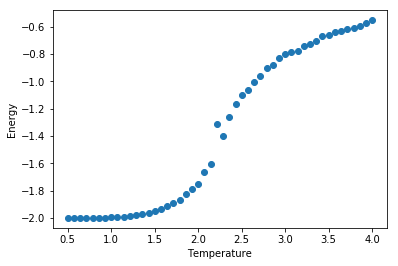

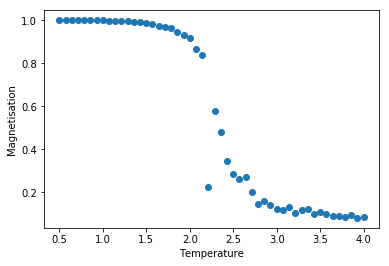

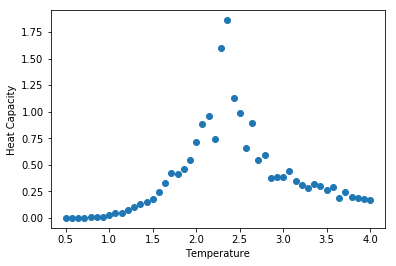

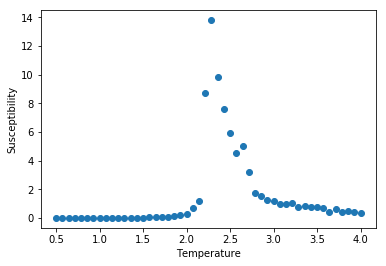

In [18]:
# Plot of energy, magnetisation, heat capacity, susceptibility against temperature
plt.plot(temperature_range,average_energy,'o')
plt.xlabel('Temperature')
plt.ylabel('Energy')
plt.savefig('plots/Energy_vs_Temperature_zeroH.png')
plt.figure()

plt.plot(temperature_range,average_magnetisation,'o')
plt.xlabel('Temperature')
plt.ylabel('Magnetisation')
plt.savefig('plots/Magnetisation_vs_Temperature_zeroH.png')
plt.figure()

plt.plot(temperature_range,average_heat_capacity,'o')
plt.xlabel('Temperature')
plt.ylabel('Heat Capacity')
plt.savefig('plots/Heat_Capacity_vs_Temperature_zeroH.png')
plt.figure()

plt.plot(temperature_range,average_susceptibility,'o')
plt.xlabel('Temperature')
plt.ylabel('Susceptibility')
plt.savefig('plots/Susceptibility_vs_Temperature_zeroH.png')
plt.figure()